In [ ]:
#--------------------------------------------------------------------------------------------------------------
!pip install open3d
!pip install nuscenes-devkit
#--------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
import pandas as pd
import numpy as np
import glob
import cv2
import os
import open3d as o3d
#--------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------
datafile = "./drive/My Drive/v1.0-mini/data/Final_Data_2_Changed.csv"
#datafile = "./drive/My Drive/v1.0-mini/data/Final_Sample_Wise_changed.csv"
dataframe = pd.read_csv(datafile)
dataframe.head()
#--------------------------------------------------------------------------------------------------------------

,index,lidar_top,radar_front,radar_front_left,radar_front_right,radar_back_left,radar_back_right,montage_image,bbox_size,num_lidar_pts,num_radar_pts,visibility_token,category_name
0,0,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.621, 0.669, 1.642]",1,0,1,pedestrian
1,1,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.775, 0.769, 1.711]",2,0,2,pedestrian
2,2,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[2.011, 4.633, 1.573]",5,0,3,vehicle_small
3,3,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.752, 0.819, 1.637]",1,0,4,pedestrian
4,4,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.427, 0.359, 0.794]",1,0,4,small_objects


In [ ]:
#--------------------------------------------------------------------------------------------------------------
def load_imagesAll(dataframe):
  images = []
  for file in dataframe:
    image = cv2.imread(file)
    image = cv2.resize(image,(128,128))
    images.append(image)

  return np.array(images)
#--------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------
def readLidarData(dataframe):
  data = []
  path = "./drive/My Drive/v1.0-mini/"
  for file in dataframe:
    pt = LidarPointCloud.from_file(path+file)
    data.append([np.sum(pt.points[0]), np.sum(pt.points[1]), np.sum(pt.points[2]), np.sum(pt.points[3])])
  print("Lidar Data Finished Loading..")
  return np.array(data)
#--------------------------------------------------------------------------------------------------------------
def readRadarData(dataframe):
  data = []
  path = "./drive/My Drive/v1.0-mini/"
  for file in dataframe:
    pcd = o3d.io.read_point_cloud(path+file)
    downpcd = pcd.voxel_down_sample(voxel_size=0.05)
    temp = downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=4))
    d1 = np.asarray(np.sum(downpcd.normals))

    pt = RadarPointCloud.from_file(path+file)

    data.append([np.sum(pt.points), d1])
  print("Radar Data Finished Loading..")
  return np.array(data)
#--------------------------------------------------------------------------------------------------------------
def readAllPointClout(dataframe):
  data = readLidarData(dataframe['lidar_top'])
  #print("Lidar Data Shape:", data.shape)

  rdata1 = readRadarData(dataframe['radar_front'])
  #print("Radar Data 1 Shape:", rdata1.shape)
  rdata2 = readRadarData(dataframe['radar_front_left'])
  #print("Radar Data 2 Shape:", rdata2.shape)
  rdata3 = readRadarData(dataframe['radar_front_right'])
  #print("Radar Data 3 Shape:", rdata3.shape)
  rdata4 = readRadarData(dataframe['radar_back_left'])
  #print("Radar Data 4 Shape:", rdata4.shape)
  rdata5 = readRadarData(dataframe['radar_back_right'])
  #print("Radar Data 5 Shape:", rdata5.shape)

  finaldata = np.column_stack((data, rdata1, rdata2, rdata3, rdata4, rdata5))
  print("Final Data Shape", finaldata.shape)
  return np.array(finaldata)
#--------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------------------------
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#------------------------------------------------------------------
# Data Preprocessing
#------------------------------------------------------------------
# Encoding Labels
labels = dataframe['category_name']
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)
le.classes_
len(labels_encoded)
#------------------------------------------------------------------

#------------------------------------------------------------------
# Creating train/test split
from sklearn.model_selection import train_test_split
#------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(dataframe, labels_encoded, test_size=0.20, random_state=20)
#------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# Loading Data
#--------------------------------------------------------------------------------------------------------------
print("Loading Image Data..")
images_train = load_imagesAll(X_train['montage_image'])
images_test  = load_imagesAll(X_test ['montage_image'])
#--------------------------------------------------------------------------------------------------------------
print("Continious Data..")
cont_data_train = X_train[['num_lidar_pts','num_radar_pts','visibility_token']]
cont_data_test  = X_test [['num_lidar_pts','num_radar_pts','visibility_token']]
#--------------------------------------------------------------------------------------------------------------
print("Loading Pointcloud Data..")
pc_train = readAllPointClout(X_train)
pc_test  = readAllPointClout(X_test)
#--------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# Normalizing continious data
mnN = preprocessing.MinMaxScaler()
mnN.fit(cont_data_train)

cont_data_train = pd.DataFrame(mnN.fit_transform(cont_data_train))
cont_data_test  = pd.DataFrame(mnN.transform(cont_data_test))

#--------------------------------------------------------------------------------------------------------------
# Normalizing pointcloud data
#--------------------------------------------------------------------------------------------------------------
mnScaler = preprocessing.MinMaxScaler()
pc_train_norm = pd.DataFrame(mnScaler.fit_transform(pc_train))
pc_test_norm  = pd.DataFrame(mnScaler.transform(pc_test))
#--------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------------------
# importing libraries
#------------------------------------------------------------
import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from keras import layers, preprocessing
from keras.models import Model
from keras.layers import *
from keras.layers import Dense, Dropout, Input
#------------------------------------------------------------

Using TensorFlow backend.


In [ ]:
#------------------------------------------------------------------
# Loading Previously Created Models
ContModel = keras.models.load_model("./drive/My Drive/v1.0-mini/model/cont_model.h5")
ImgModel  = keras.models.load_model("./drive/My Drive/v1.0-mini/model/image_model.h5")
PCModel   = keras.models.load_model("./drive/My Drive/v1.0-mini/model/pc_model.h5")
#------------------------------------------------------------------

In [ ]:
batch_size = 64
#------------------------------------------------------------------
# Individual Model Testing and Prediction
print("Continious Data Prediction..")
ContPrediction = ContModel.predict(cont_data_test, batch_size=batch_size)
print("Image Data Prediction..")
ImagePrediction = ImgModel.predict(images_test, batch_size=batch_size)
print("Pointcloud Data Prediction..")
PCPrediction = PCModel.predict(pc_test_norm, batch_size=batch_size)


Continious Data Prediction..
Image Data Prediction..
Pointcloud Data Prediction..


In [ ]:
#------------------------------------------------------------------
finalpred = (ImagePrediction*0.4 + PCPrediction*0.35 + ContPrediction*0.25)
#print("Final weighted Average", finalpred)
np.max(finalpred, axis=0)

array([0.47964042, 0.46955487, 0.35966277, 0.86139315], dtype=float32)

In [ ]:
#------------------------------------------------------------------
# Combined Model
#------------------------------------------------------------------
combinedInput = layers.concatenate([ContModel.output, ImgModel.output, PCModel.output])
#combinedInput = Flatten()(combinedInput)
combinedInput = Dense(16, name="lb_100")(combinedInput)
combinedInput = Dropout(0.5, name="lb_102")(combinedInput)
combinedInput = Dense(8, name="lb_101")(combinedInput)
combinedInput = Dropout(0.5, name="lb_103")(combinedInput)
combinedInput = Dense(4, activation="softmax", name='main_output')(combinedInput)
combinedModel = Model([ContModel.input, ImgModel.input, PCModel.input], combinedInput)
print(combinedInput.shape)
#------------------------------------------------------------------

(None, 4)


In [ ]:
#------------------------------------------------------------------
keras.utils.plot_model(combinedModel, show_shapes=True)
#------------------------------------------------------------------
combinedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 64, 64, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
epochs = 15
#------------------------------------------------------------------
# Training Model
#------------------------------------------------------------------
callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
combinedModel.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
Hist = combinedModel.fit(
    [cont_data_train, images_train, pc_train_norm], y_train,
    epochs = epochs, shuffle="true", batch_size=batch_size,
    validation_data = ([cont_data_test, images_test, pc_test_norm], y_test)
)
#------------------------------------------------------------------

Train on 14830 samples, validate on 3708 samples
Epoch 1/15
14830/14830 [==============================] - 2081s 140ms/step - loss: 1.1328 - accuracy: 0.5246 - val_loss: 1.1655 - val_accuracy: 0.4830
Epoch 2/15
14830/14830 [==============================] - 2083s 140ms/step - loss: 1.0556 - accuracy: 0.5559 - val_loss: 1.0933 - val_accuracy: 0.5235
Epoch 3/15
14830/14830 [==============================] - 2075s 140ms/step - loss: 1.0314 - accuracy: 0.5577 - val_loss: 1.0408 - val_accuracy: 0.5216
Epoch 4/15
14830/14830 [==============================] - 2073s 140ms/step - loss: 1.0182 - accuracy: 0.5670 - val_loss: 0.9377 - val_accuracy: 0.5955
Epoch 5/15
14830/14830 [==============================] - 2070s 140ms/step - loss: 1.0073 - accuracy: 0.5638 - val_loss: 0.9905 - val_accuracy: 0.5928
Epoch 6/15
14830/14830 [==============================] - 2079s 140ms/step - loss: 1.0052 - accuracy: 0.5655 - val_loss: 1.2835 - val_accuracy: 0.4730
Epoch 7/15
14830/14830 [=====================

In [ ]:
#------------------------------------------------------------------
# Saving Model for later use
#------------------------------------------------------------------
combinedModel.save("./drive/My Drive/v1.0-mini/model/combined_model.h5")  # creates a HDF5 file
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = keras.models.load_model("./drive/My Drive/Amit/my_model.h5")
#------------------------------------------------------------------

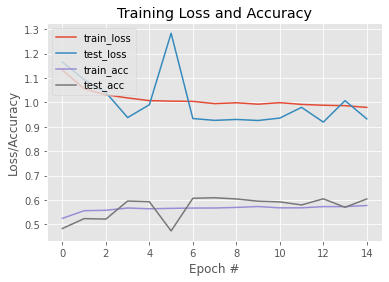

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="test_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 4060],
       [   1, 3031],
       [   2, 1058],
       [   3, 6681]])

In [ ]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0,  980],
       [   1,  819],
       [   2,  257],
       [   3, 1652]])